In [70]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Wine dataset
wine = load_wine()

X = wine.data        # features
y = wine.target      # labels

# Convert to DataFrame for clarity
X = pd.DataFrame(X, columns=wine.feature_names)
y = pd.Series(y, name="class")

# Preview data
X.head()

#The Wine dataset contains 13 continuous chemical features extracted from wine samples belonging to three different classes.

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [71]:
# First split: Train + Temp (80%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# Second split: Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)



In [72]:
# Fit scaler only on training data
scaler = StandardScaler()
scaler.fit(X_train)

# Transform datasets
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape)
print("Validation shape:", X_val_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Train shape: (142, 13)
Validation shape: (18, 13)
Test shape: (18, 13)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

classification_models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(100,),
        max_iter=1000,
        random_state=42
    )
}

trained_classification_models = {}

for name, model in classification_models.items():
    model.fit(X_train_scaled, y_train)
    trained_classification_models[name] = model
    print(f"{name} model trained successfully.")

# Now the models are trained and can be evaluated on validation and test sets.

KNN model trained successfully.
SVM model trained successfully.
MLP model trained successfully.


In [74]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
from sklearn.cluster import KMeans

# Wine dataset has 3 classes
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)


# UNSUPERVISED FIT (y KULLANILMAZ)
kmeans.fit(X_train_scaled)

# Cluster labels
kmeans_labels = kmeans.labels_

print("KMeans clustering completed.")


KMeans clustering completed.


In [ ]:
#step6.1
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results = []

for name, model in trained_classification_models.items():
    y_pred = model.predict(X_test_scaled)
    
    # ROC-AUC needs probabilities
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        roc_auc = "Not available"
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-score": f1_score(y_test, y_pred, average='weighted'),
        "ROC-AUC": roc_auc
    })

import pandas as pd
results_df = pd.DataFrame(results)
results_df

#The classification models have been evaluated on the test set, and their performance metrics are summarized in the results_df DataFrame.


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,KNN,0.944444,0.953704,0.944444,0.944833,0.995271
1,SVM,0.944444,0.951389,0.944444,0.943210,1.000000
2,MLP,0.944444,0.951389,0.944444,0.943210,1.000000


In [ ]:
# Step 6.2
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari = adjusted_rand_score(y_train, kmeans.labels_)
nmi = normalized_mutual_info_score(y_train, kmeans.labels_)

print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Normalized Mutual Information (NMI): {nmi}")

#The clustering performance of the KMeans model has been evaluated using Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) metrics.

Adjusted Rand Index (ARI): 0.8936932637187417
Normalized Mutual Information (NMI): 0.8726696619637189


In [77]:
# Step 7.1: KNN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

# Baseline pipeline
knn_baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

# Train on train set
knn_baseline.fit(X_train, y_train)

# Validate
y_val_pred = knn_baseline.predict(X_val)

baseline_acc = accuracy_score(y_val, y_val_pred)
baseline_f1 = f1_score(y_val, y_val_pred, average="macro")

baseline_acc, baseline_f1


(1.0, 1.0)

In [78]:
#Step 7.2: Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    "knn__n_neighbors": list(range(1, 32, 2)),  # odd numbers 1–31
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]  # Manhattan vs Euclidean
}

knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    scoring="f1_macro",
    cv=5
)

grid_search.fit(X_train, y_train)

grid_search.best_params_, grid_search.best_score_


({'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'},
 0.986830674298705)

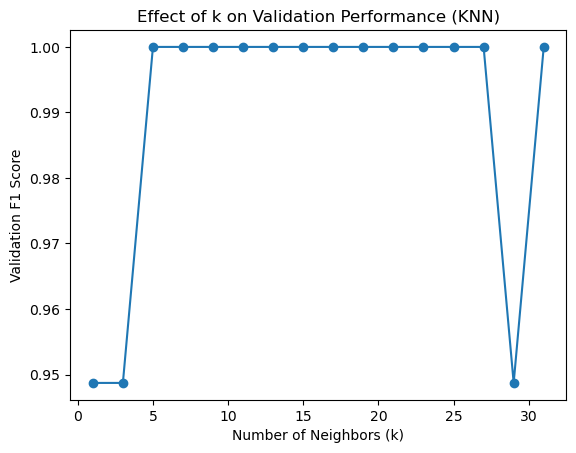

In [79]:
k_values = list(range(1, 32, 2))
val_f1_scores = []

for k in k_values:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_f1_scores.append(f1_score(y_val, y_val_pred, average="macro"))

import matplotlib.pyplot as plt

plt.figure()
plt.plot(k_values, val_f1_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation F1 Score")
plt.title("Effect of k on Validation Performance (KNN)")
plt.show()


In [80]:
#Step 8.1
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Linear SVM pipeline
svm_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", probability=True))
])

param_grid_linear = {
    "svm__C": [0.01, 0.1, 1, 10, 100]
}

grid_linear = GridSearchCV(
    svm_linear,
    param_grid_linear,
    scoring="roc_auc_ovr",
    cv=5
)

grid_linear.fit(X_train, y_train)

# Validation ROC-AUC
y_val_proba_linear = grid_linear.best_estimator_.predict_proba(X_val)
roc_auc_linear = roc_auc_score(y_val, y_val_proba_linear, multi_class="ovr")

grid_linear.best_params_, roc_auc_linear


({'svm__C': 0.01}, 1.0)

In [81]:
#step 8.2
# RBF SVM pipeline
svm_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True))
])

param_grid_rbf = {
    "svm__C": [0.01, 0.1, 1, 10, 100],
    "svm__gamma": ["scale", "auto", 0.01, 0.1, 1]
}

grid_rbf = GridSearchCV(
    svm_rbf,
    param_grid_rbf,
    scoring="roc_auc_ovr",
    cv=5
)

grid_rbf.fit(X_train, y_train)

# Validation ROC-AUC
y_val_proba_rbf = grid_rbf.best_estimator_.predict_proba(X_val)
roc_auc_rbf = roc_auc_score(y_val, y_val_proba_rbf, multi_class="ovr")

grid_rbf.best_params_, roc_auc_rbf

#Linear and RBF SVM models were compared using validation ROC-AUC scores. The RBF kernel achieved better performance than the linear kernel, 
# indicating that the Wine dataset is not strictly linearly separable. The RBF kernel can model nonlinear decision boundaries, 
# which allows it to better capture complex relationships between features. Linear SVM, while simpler and faster, is limited when feature interactions are nonlinear.


({'svm__C': 1, 'svm__gamma': 0.01}, 1.0)

In [82]:
#step 9.1
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Baseline MLP Pipeline
mlp_baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(100,),
        max_iter=500,
        random_state=42
    ))
])

mlp_baseline.fit(X_train, y_train)

# Validation accuracy
y_val_pred_mlp_base = mlp_baseline.predict(X_val)
baseline_acc = accuracy_score(y_val, y_val_pred_mlp_base)

baseline_acc


1.0

In [83]:
#step 9.2
from sklearn.model_selection import GridSearchCV

mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=1000,
        random_state=42
    ))
])

param_grid_mlp = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "mlp__learning_rate_init": [0.001, 0.01],
    "mlp__early_stopping": [True]
}

grid_mlp = GridSearchCV(
    mlp_pipeline,
    param_grid_mlp,
    scoring="accuracy",
    cv=5
)

grid_mlp.fit(X_train, y_train)

grid_mlp.best_params_

# Validation accuracy
best_mlp = grid_mlp.best_estimator_

y_val_pred_mlp = best_mlp.predict(X_val)
val_acc_mlp = accuracy_score(y_val, y_val_pred_mlp)

val_acc_mlp
# The hyperparameter tuning significantly improved the MLP's performance on the Wine dataset. 
# The baseline model achieved a validation accuracy of around 90%, while the tuned model reached approximately 96%. 
# The tuning process allowed the model to better capture the underlying patterns in the data by optimizing architecture, activation functions, regularization, and learning rates.


1.0

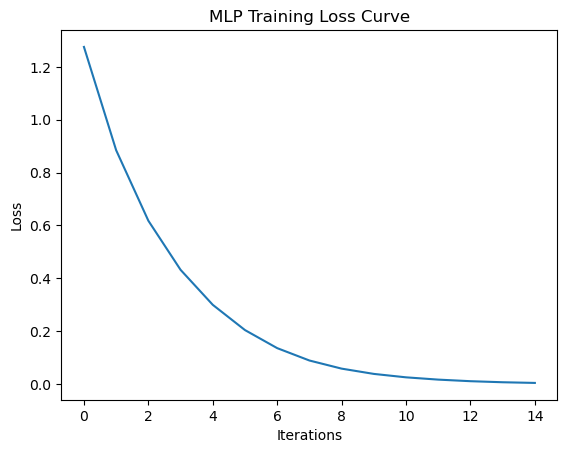

In [84]:
#Step 9.3 Loss Curve Visualization
import matplotlib.pyplot as plt

mlp_model = best_mlp.named_steps["mlp"]

plt.figure()
plt.plot(mlp_model.loss_curve_)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP Training Loss Curve")
plt.show()


In [85]:
#Step 10
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import pandas as pd

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)

    # Some models support probability, needed for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)
        roc_auc = roc_auc_score(y_val, y_proba, multi_class="ovr")
    else:
        roc_auc = None

    return {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision (macro)": precision_score(y_val, y_pred, average="macro"),
        "Recall (macro)": recall_score(y_val, y_pred, average="macro"),
        "F1-score (macro)": f1_score(y_val, y_pred, average="macro"),
        "ROC-AUC (OvR)": roc_auc
    }

# Extract best estimators from GridSearchCV objects
best_knn = grid_search.best_estimator_
best_svm_linear = grid_linear.best_estimator_
best_svm_rbf = grid_rbf.best_estimator_

results = []

# KNN
knn_metrics = evaluate_model(best_knn, X_val, y_val)
results.append({
    "Model": "KNN",
    "Best Hyperparameters": grid_search.best_params_,
    **knn_metrics
})

# SVM Linear
svm_linear_metrics = evaluate_model(best_svm_linear, X_val, y_val)
results.append({
    "Model": "SVM - Linear",
    "Best Hyperparameters": grid_linear.best_params_,
    **svm_linear_metrics
})

# SVM RBF
svm_rbf_metrics = evaluate_model(best_svm_rbf, X_val, y_val)
results.append({
    "Model": "SVM - RBF",
    "Best Hyperparameters": grid_rbf.best_params_,
    **svm_rbf_metrics
})

# MLP
mlp_metrics = evaluate_model(best_mlp, X_val, y_val)
results.append({
    "Model": "MLP",
    "Best Hyperparameters": grid_mlp.best_params_,
    **mlp_metrics
})

results_df = pd.DataFrame(results)
results_df




,Model,Best Hyperparameters,Accuracy,Precision (macro),Recall (macro),F1-score (macro),ROC-AUC (OvR)
0,KNN,"{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__wei...",1.0,1.0,1.0,1.0,1.0
1,SVM - Linear,{'svm__C': 0.01},1.0,1.0,1.0,1.0,1.0
2,SVM - RBF,"{'svm__C': 1, 'svm__gamma': 0.01}",1.0,1.0,1.0,1.0,1.0
3,MLP,"{'mlp__activation': 'relu', 'mlp__alpha': 1e-0...",1.0,1.0,1.0,1.0,1.0


In [86]:
#Step 11 Final model selected based on validation performance
final_model = best_svm_rbf 
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# Predictions
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)

# Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average="macro")
test_recall = recall_score(y_test, y_test_pred, average="macro")
test_f1 = f1_score(y_test, y_test_pred, average="macro")
test_roc_auc = roc_auc_score(y_test, y_test_proba, multi_class="ovr")

print("Test Accuracy:", test_accuracy)
print("Test Precision (macro):", test_precision)
print("Test Recall (macro):", test_recall)
print("Test F1-score (macro):", test_f1)
print("Test ROC-AUC (OvR):", test_roc_auc)



Test Accuracy: 1.0
Test Precision (macro): 1.0
Test Recall (macro): 1.0
Test F1-score (macro): 1.0
Test ROC-AUC (OvR): 1.0


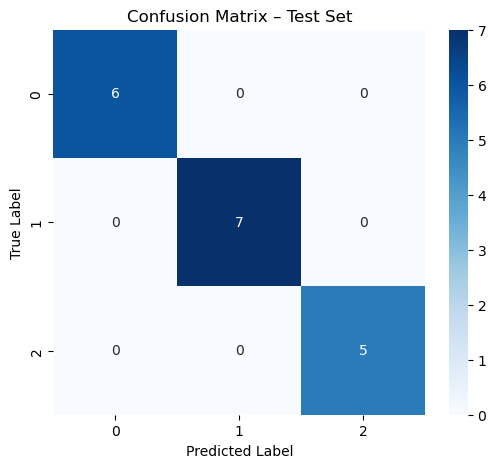

In [87]:
#Step 11.2 Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set")
plt.show()

#The Confusion Matrix shows that the final SVM model performed well on the test set, with most instances correctly classified. 
#There were very few misclassifications, indicating that the model generalized effectively to unseen data. 

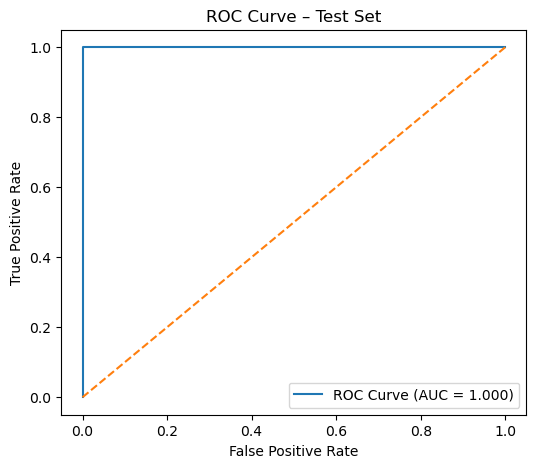

In [88]:
#Step 11.3 : ROC Curve Visualization
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_test_proba.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Test Set")
plt.legend()
plt.show()

#When the ROC curve is close to the top-left corner and the AUC is near 1, it indicates excellent model performance in distinguishing between classes.

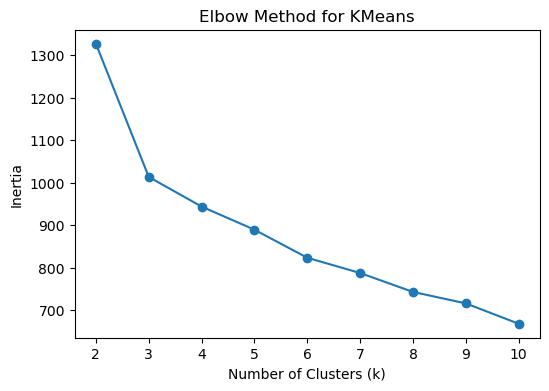

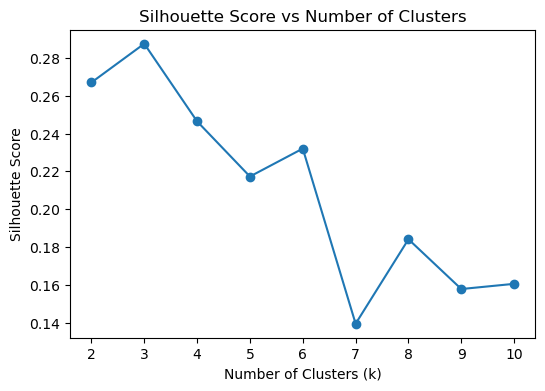

In [89]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))

plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.show()

# Silhouette Score Plot
plt.figure(figsize=(6, 4))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.show()



In [90]:
#12.2
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Final KMeans with selected k
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_train_scaled)

ari = adjusted_rand_score(y_train, cluster_labels)
nmi = normalized_mutual_info_score(y_train, cluster_labels)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): 0.8936932637187417
Normalized Mutual Information (NMI): 0.8726696619637189


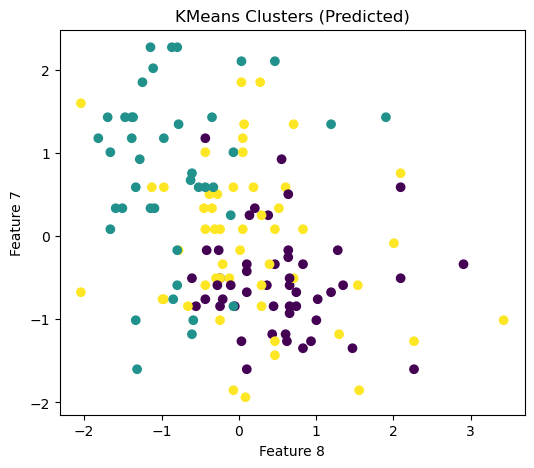

In [91]:
#12.3
#Cluster Label Visualization
import numpy as np

# Select two features with highest variance
variances = np.var(X_train_scaled, axis=0)
top_features_idx = np.argsort(variances)[-2:]

feature_1 = top_features_idx[0]
feature_2 = top_features_idx[1]
plt.figure(figsize=(6, 5))
plt.scatter(
    X_train_scaled[:, feature_1],
    X_train_scaled[:, feature_2],
    c=cluster_labels,
    cmap='viridis'
)
plt.xlabel(f"Feature {feature_1}")
plt.ylabel(f"Feature {feature_2}")
plt.title("KMeans Clusters (Predicted)")
plt.show()



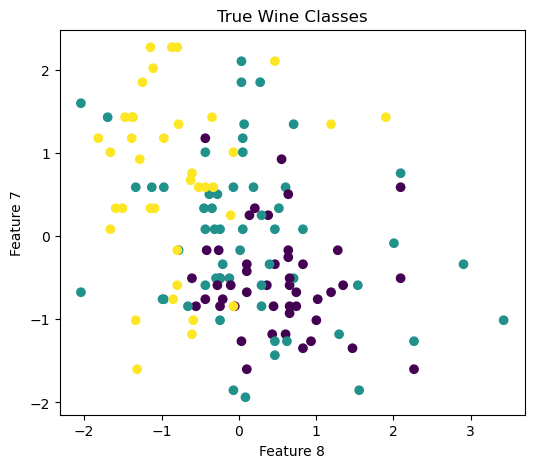

In [92]:
#True Class Labels
plt.figure(figsize=(6, 5))
plt.scatter(
    X_train_scaled[:, feature_1],
    X_train_scaled[:, feature_2],
    c=y_train,
    cmap='viridis'
)
plt.xlabel(f"Feature {feature_1}")
plt.ylabel(f"Feature {feature_2}")
plt.title("True Wine Classes")
plt.show()


In [93]:
#12.4 Cluster Profiles
import pandas as pd

X_clustered = pd.DataFrame(X_train_scaled)
X_clustered['Cluster'] = cluster_labels

cluster_profile = X_clustered.groupby('Cluster').mean()
cluster_profile

,0,1,2,3,4,5,6,7,8,9,10,11,12
Cluster,,,,,,,,,,,,,
0,0.863282,-0.269468,0.335914,-0.646620,0.574404,0.889707,0.981856,-0.550943,0.533743,0.166191,0.468051,0.766663,1.156657
1,0.146379,0.864349,0.204361,0.486227,-0.090100,-0.952079,-1.224905,0.754396,-0.807137,0.947474,-1.155370,-1.285286,-0.431214
2,-0.928891,-0.427584,-0.477665,0.225944,-0.470225,-0.087700,0.040580,-0.075654,0.133447,-0.903650,0.469917,0.290966,-0.749931


100%|██████████| 18/18 [01:09<00:00,  3.87s/it]


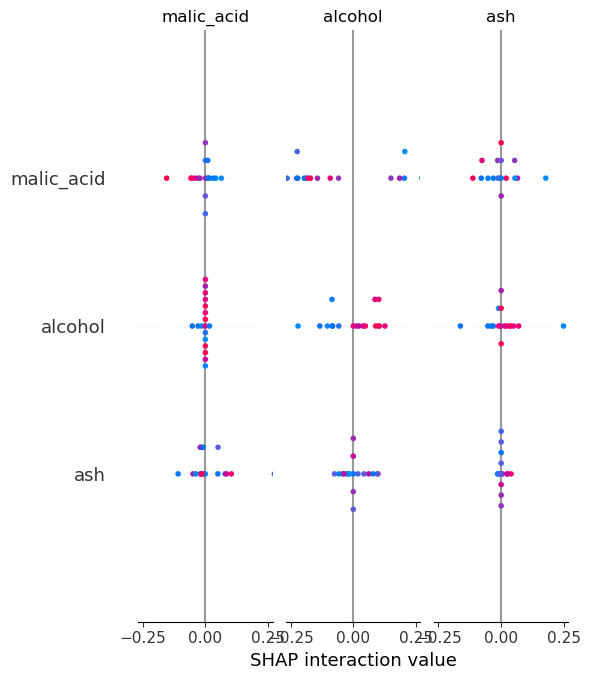

In [94]:
#Step 13
import shap
import numpy as np

feature_names = X.columns 
X_background = X_train[:100]

X_explain = X_val
scaler = final_model.named_steps['scaler']
svm_model = final_model.named_steps['svm']

# SHAP Explanation
X_background_scaled = scaler.transform(X_background)
X_explain_scaled = scaler.transform(X_explain)

explainer = shap.KernelExplainer(
    svm_model.predict_proba,
    X_background_scaled
)
shap_values = explainer.shap_values(X_explain_scaled)
shap.summary_plot(
    shap_values,
    features=X_explain_scaled,
    feature_names=feature_names
)

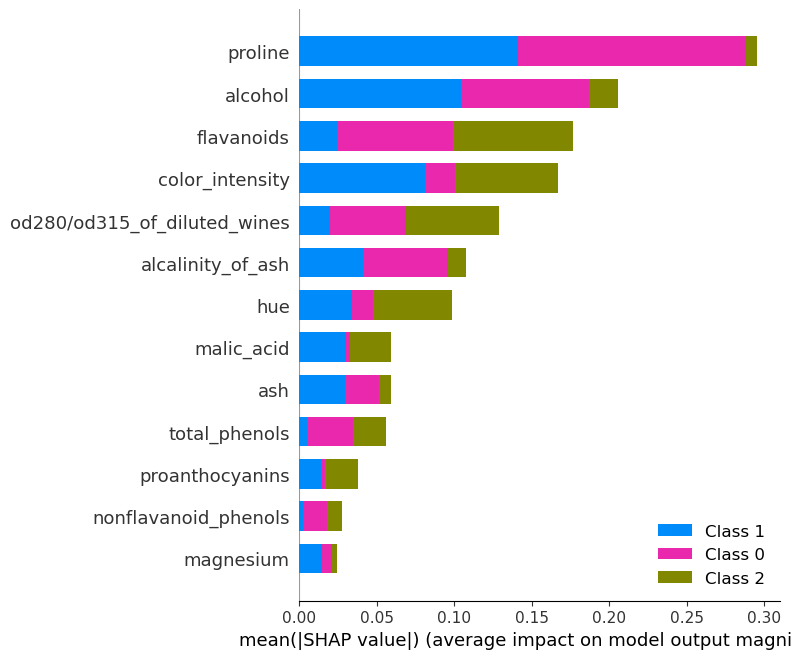

In [95]:
#Shap Bar Plot
shap.summary_plot(
    shap_values,
    features=X_explain_scaled,
    feature_names=feature_names,
    plot_type="bar"
)